In [267]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Forecast as fc
import pickle

In [268]:
# loading data

provinces = pd.read_csv('..\data\dati-province\dpc-covid19-ita-province.csv')
today = '2021-06-26T17:00:00'
today_data = provinces.loc[provinces['data']==today]

population = pd.read_csv('..\data\Popolazione_province.csv', index_col=0)

p_list = pd.read_csv('..\data\Provinces_list.csv')['Sigla'].tolist()

# Load the coordinates from the file
with open('..\data\coordinates_dict.pickle', 'rb') as file:
    coord_df = pickle.load(file)

# Load the distances from the file
with open('..\data\distances_df.pickle', 'rb') as file:
    distances_df = pickle.load(file)

In [269]:
# Load the dictionary from the file
with open('..\data\provinces_fit.pickle', 'rb') as file:
    provinces_fitted = pickle.load(file)

selected_start=200
wave_index = [[i for i, t in enumerate(provinces_fitted[sigla].L_starts) if t>selected_start][0] for sigla in p_list]
wave_params = [ provinces_fitted[sigla].L_waves[wave_index[i]].params  for i, sigla in enumerate(p_list)]
K0 = 100
b0 = 25
c0 = 0.1
z1 = [param['K'].value/K0 for param in wave_params]
z2 = [param['b'].value/b0 for param in wave_params]
z3 = [param['c'].value/c0 for param in wave_params]
z4 = [param['t_max'].value for param in wave_params]

In [270]:
test_labels = ['MO','RO', 'VI', 'AL', 'BI', 'PN', 'MB']
data_labels = [sigla for sigla in p_list if not(sigla in test_labels)]
x_data = [ coord_df[sigla][0]/100000 for sigla in (data_labels) ]
y_data = [ coord_df[sigla][1]/100000 for sigla in (data_labels) ]
x_test = [ coord_df[sigla][0]/100000 for sigla in (test_labels) ]
y_test = [ coord_df[sigla][1]/100000 for sigla in (test_labels) ]

In [271]:
selected_start=200
data_wave_index = [[i for i, t in enumerate(provinces_fitted[sigla].L_starts) if t>selected_start][0] for sigla in data_labels]
data_wave_params = [ provinces_fitted[sigla].L_waves[data_wave_index[i]].params  for i, sigla in enumerate(data_labels)]
K0 = 100
b0 = 25
c0 = 0.1
z1_data = [param['K'].value/K0 for param in data_wave_params]
z2_data = [param['b'].value/b0 for param in data_wave_params]
z3_data = [param['c'].value/c0 for param in data_wave_params]

test_wave_index = [[i for i, t in enumerate(provinces_fitted[sigla].L_starts) if t>selected_start][0] for sigla in test_labels]
test_wave_params = [ provinces_fitted[sigla].L_waves[test_wave_index[i]].params  for i, sigla in enumerate(test_labels)]
z1_test = [param['K'].value/K0 for param in test_wave_params]
z2_test = [param['b'].value/b0 for param in test_wave_params]
z3_test = [param['c'].value/c0 for param in test_wave_params]

In [272]:
# Radial basis Function approach

def RBF(z_data, coor_data, coor_test, sigma):
    n_data = len(coor_data[0])
    n_test = len(coor_test[0])

    def radial_basis(x,y,sigma):
        return np.exp(-x**2-y**2)
        return 1./(1+(x**2 + y**2)/sigma**2)

    # Initial shape model
    z_m = [sum(z_data[0])/len(z_data[0]), sum(z_data[1])/len(z_data[1]), sum(z_data[2])/len(z_data[2]) ]

    S = np.zeros((n_data, n_data, 3))
    Delta = np.zeros((n_data, 3))
    W = np.zeros((n_data, 3))
    for k in range(3):
        for i in range(n_data):
            for j in range(n_data):
                S[i,j,k] = radial_basis( coor_data[0][i]-coor_data[0][j], coor_data[1][i]-coor_data[1][j], sigma[k] )

    # Compute delta
    for k in range(3):
        for i in range(n_data):
            Delta[i][k] = z_data[k][i]-z_m[k]

    # Compute Weights
    for k in range(3):
        W[:,k] = np.linalg.solve(S[:,:,k],Delta[:,k])

    # Extimation in the test set
    Z_RBF = np.zeros((n_test, 3))
    for k in range(3):
        Z_RBF[:,k] = z_m[k]*np.ones(n_test)
    for k in range(3):
        for i in range(n_test):
            for j in range(n_data):
                Z_RBF[i, k] = Z_RBF[i, k] +  W[j,k]*radial_basis( (coor_test[0][i] - coor_data[0][j]), (coor_test[1][i] - coor_data[1][j]), sigma[k] )

    return Z_RBF, z_m

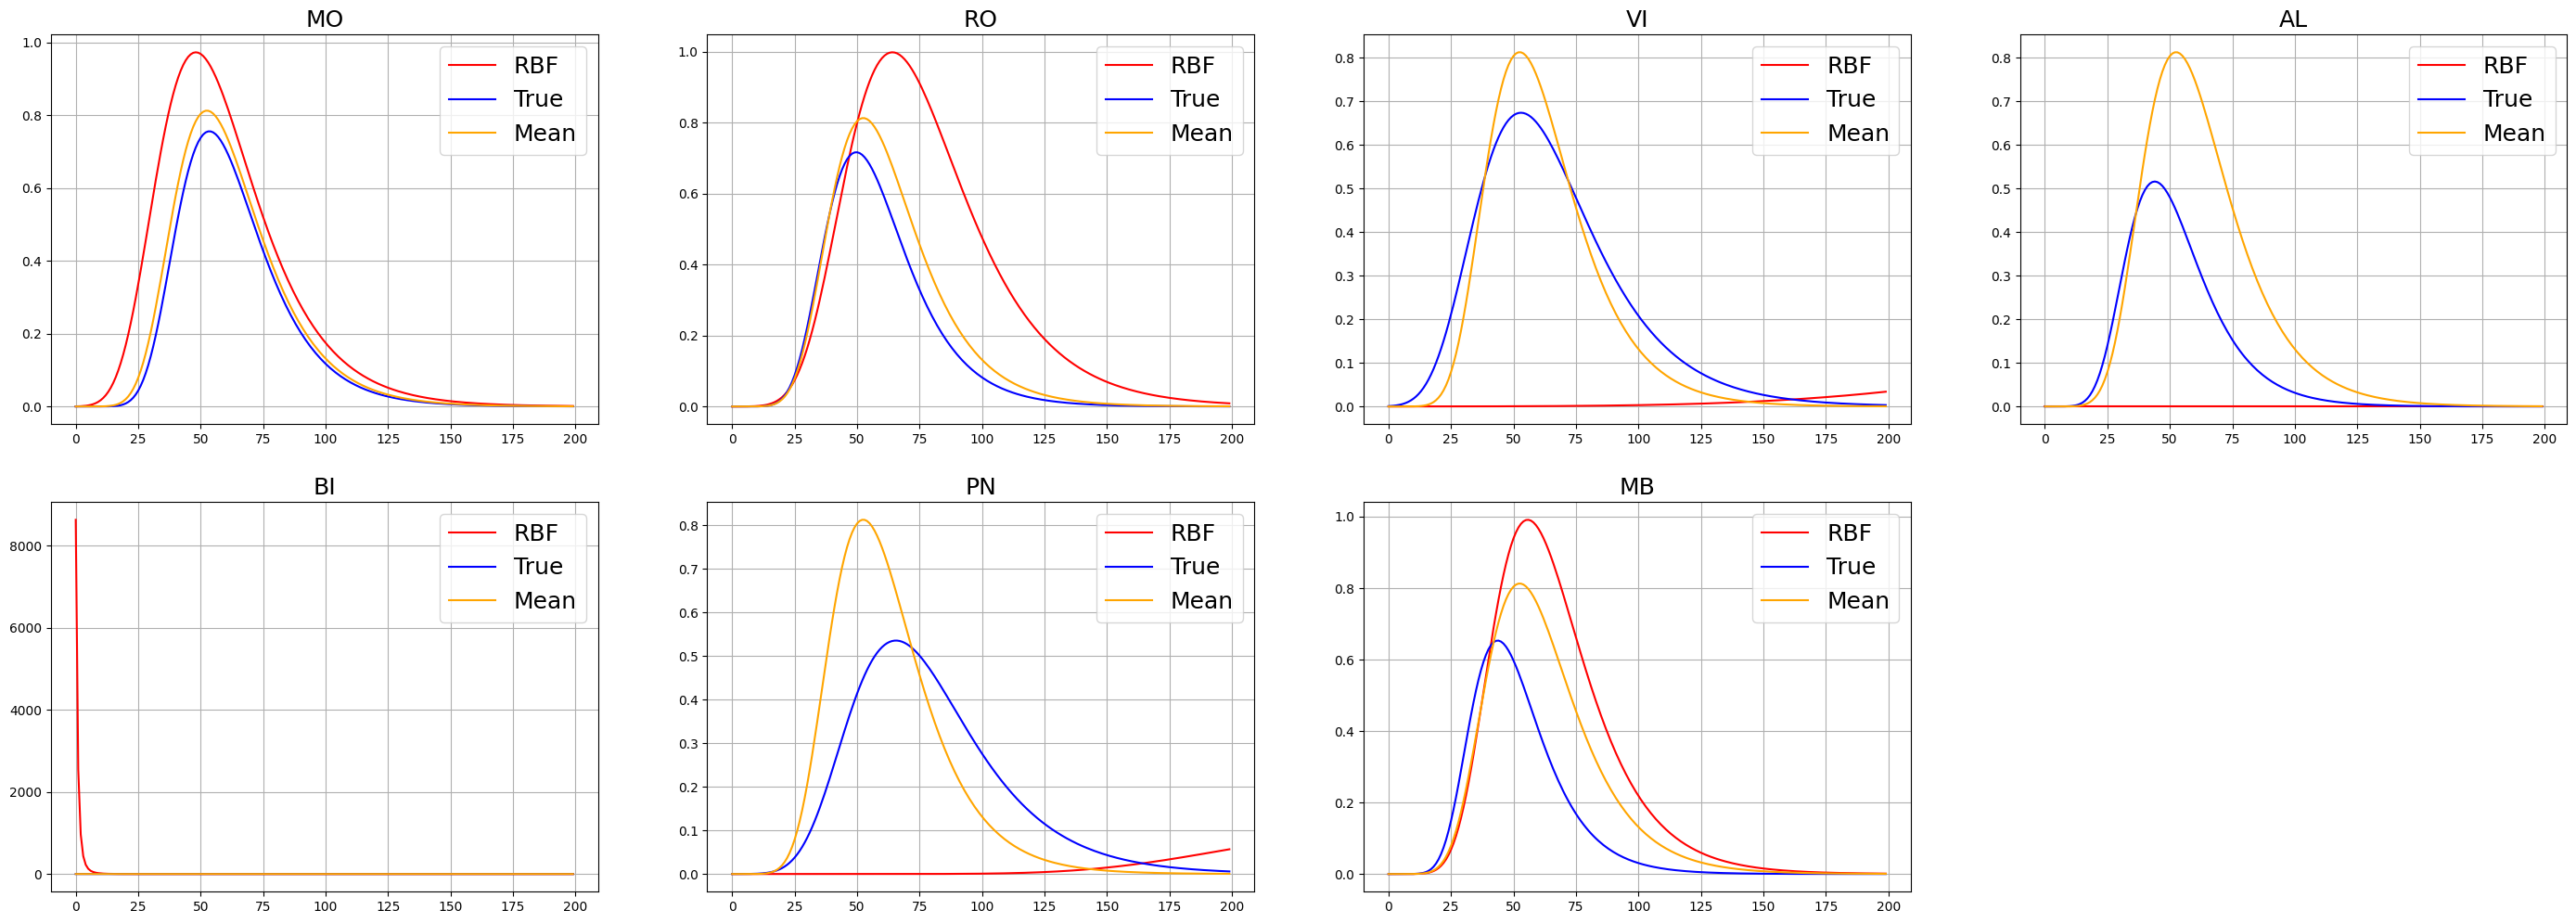

In [273]:
sigma = [0.1, 0.1, 0.1]
Z_RBF, z_m= RBF([z1_data, z2_data, z3_data], [x_data, y_data], [x_test, y_test], sigma)
Z_target = np.array([z1_test, z2_test, z3_test]).T
# Plotting curves
tt = np.arange(0,200)
plt.figure(figsize=(35,12))
j=0
for i,sigla in enumerate(test_labels):
    index = p_list.index(sigla)
    plt.subplot(2,4,j+1)
    plt.title(sigla, fontsize=18)
    plt.grid(True)
    wave_RBF = fc.gompertz(tt,Z_RBF[i][0]*K0, Z_RBF[i][1]*b0, Z_RBF[i][2]*c0)
    wave_m = fc.gompertz(tt,z_m[0]*K0, z_m[1]*b0, z_m[2]*c0)
    wave_true = fc.gompertz(tt,z1[index]*K0, z2[index]*b0, z3[index]*c0)
    plt.plot(tt,wave_RBF, color='red', label='RBF')
    plt.plot(tt,wave_true, color='blue', label='True')
    plt.plot(tt,wave_m, color='orange', label='Mean')
    plt.legend( fontsize=18)
    j+=1

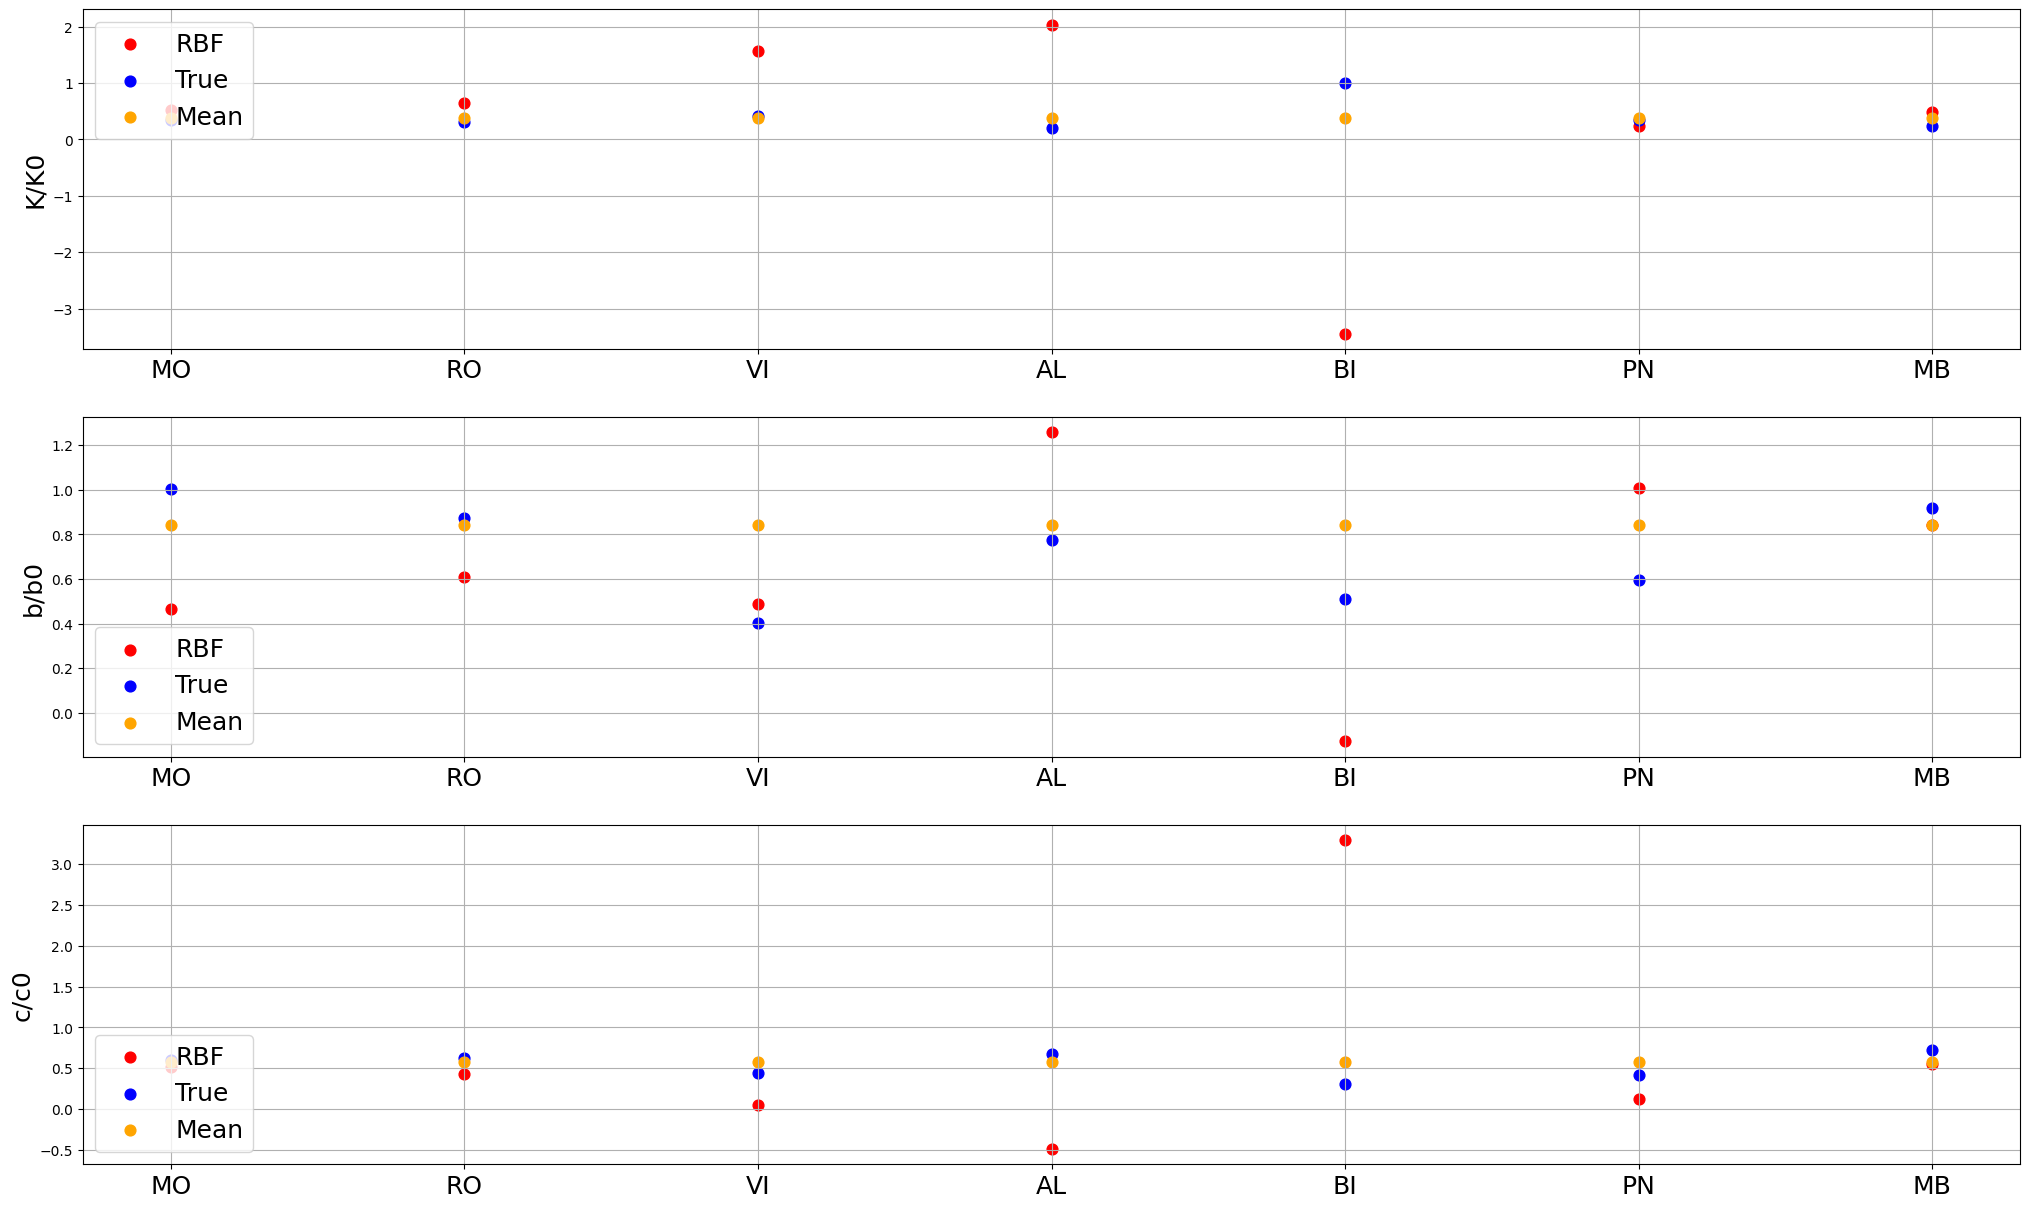

In [274]:
ms=[60]
plt.figure(figsize=(25,15))
for i,sigla in enumerate(test_labels):
    index = p_list.index(sigla)
    plt.subplot(3,1,1)
    plt.scatter(i, Z_RBF[i][0], color='red', sizes=ms)
    plt.scatter(i, z1[index], color='blue', sizes=ms)
    plt.scatter(i, z_m[0], color='orange', sizes=ms)
    plt.xticks(np.arange(0,len(test_labels)),test_labels, fontsize=18)
    plt.ylabel('K/K0', fontsize=18)
    plt.grid(True)
    plt.legend(['RBF','True', 'Mean'], fontsize=18, loc=2)

    plt.subplot(3,1,2)
    plt.scatter(i, Z_RBF[i][1], color='red', sizes=ms)
    plt.scatter(i, z2[index], color='blue', sizes=ms)
    plt.scatter(i, z_m[1], color='orange', sizes=ms)
    plt.xticks(np.arange(0,len(test_labels)),test_labels, fontsize=18)
    plt.ylabel('b/b0', fontsize=18)
    plt.grid(True)
    plt.legend(['RBF','True', 'Mean'], fontsize=18, loc=3)

    plt.subplot(3,1,3)
    plt.scatter(i, Z_RBF[i][2], color='red', sizes=ms)
    plt.scatter(i, z3[index], color='blue', sizes=ms)
    plt.scatter(i, z_m[2], color='orange', sizes=ms)
    plt.xticks(np.arange(0,len(test_labels)),test_labels, fontsize=18)
    plt.ylabel('c/c0', fontsize=18)
    plt.grid(True)
    plt.legend(['RBF','True', 'Mean'], fontsize=18, loc=3)

In [275]:

def CostFunctional(sigma, ystar, z_data, coor_data, coor_test):
    def inputOutput(sigma):
        yh, ym = RBF(z_data, coor_data, coor_test, sigma)
        return yh
    
    # print('Evaluating Cost Functional at: ['+str(sigma[0])+','+str(sigma[1])+','+str(sigma[2])+']')
    yh = inputOutput(sigma)
    error = 0
    for i in range(len(test_labels)):
        wave_h = fc.gompertz(tt,yh[i][0]*K0, yh[i][1]*b0, yh[i][2]*c0)
        wave_star = fc.gompertz(tt,ystar[i][0]*K0, ystar[i][1]*b0, ystar[i][2]*c0)
        error = error + ((wave_star-wave_h)**2).mean(axis=None)
    return ((ystar-yh)**2).mean(axis=None)
    

advancing: 0.0%
advancing: 6.666666666666667%
advancing: 13.333333333333334%
advancing: 20.0%
advancing: 26.666666666666668%
advancing: 33.33333333333333%
advancing: 40.0%
advancing: 46.666666666666664%
advancing: 53.333333333333336%
advancing: 60.0%
advancing: 66.66666666666666%
advancing: 73.33333333333333%
advancing: 80.0%
advancing: 86.66666666666667%
advancing: 93.33333333333333%
[1e-05, 1e-05, 1e-05]


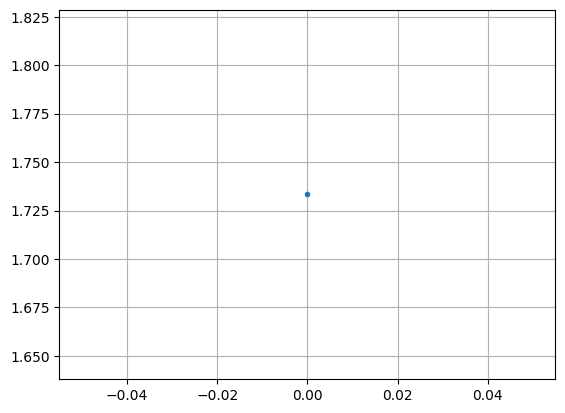

In [276]:

# Define a grid for Sigma
s1 = np.linspace(0.00001,1, 15)
s2 = np.linspace(0.00001,1, 15)
s3 = np.linspace(0.00001,1, 15)
J = 1e12
J_list=[]

for i, x in enumerate(s1):
    print('advancing: '+str(i/s1.shape[0]*100)+'%')
    for y in s2:
        for z in s3:
            c = CostFunctional([x,y,z],Z_target,[z1_data, z2_data, z3_data], [x_data, y_data], [x_test, y_test])
            if c < J:
                J = c
                J_list.append(J)
                sigma_opt = [x,y,z]

print(sigma_opt)
plt.figure()
plt.plot(J_list, marker='.')
plt.grid(True)


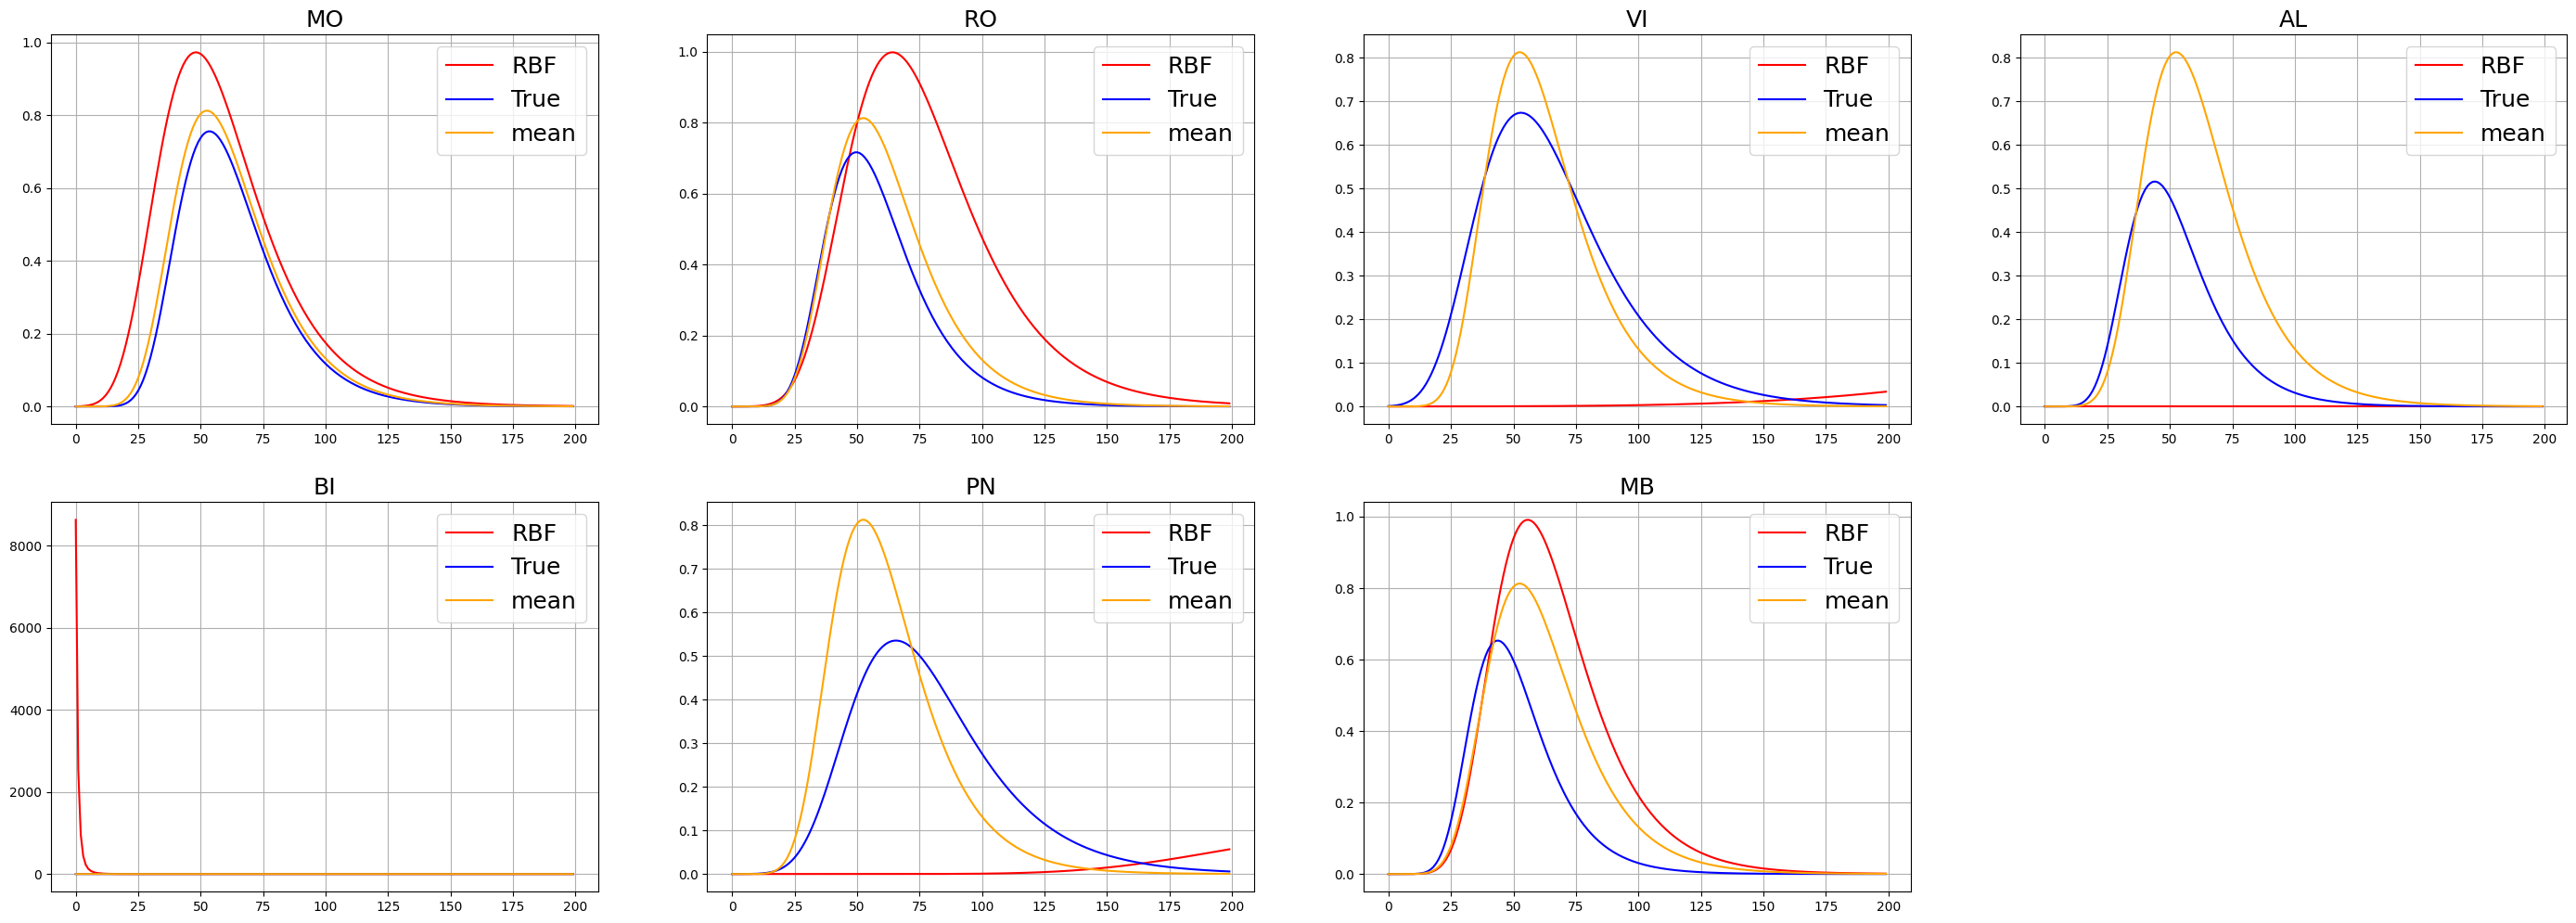

In [277]:

Z_RBF, z_m = RBF([z1_data, z2_data, z3_data], [x_data, y_data], [x_test, y_test], sigma)
plt.figure(figsize=(35,12))
j=0
for i,sigla in enumerate(test_labels):
    index = p_list.index(sigla)
    plt.subplot(2,4,j+1)
    plt.title(sigla, fontsize=18)
    plt.grid(True)
    wave_RBF = fc.gompertz(tt,Z_RBF[i][0]*K0, Z_RBF[i][1]*b0, Z_RBF[i][2]*c0)
    wave_m = fc.gompertz(tt,z_m[0]*K0, z_m[1]*b0, z_m[2]*c0)
    wave_true = fc.gompertz(tt,z1[index]*K0, z2[index]*b0, z3[index]*c0)
    plt.plot(tt,wave_RBF, color='red', label='RBF')
    plt.plot(tt,wave_true, color='blue', label='True')
    plt.plot(tt,wave_m, color='orange', label='mean')
    plt.legend( fontsize=18)
    j+=1
